In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as LM
from sklearn import preprocessing as prp
from sklearn.metrics import f1_score
%matplotlib inline

## идея работы такая:
1) подгружаем данные из hdf файла

2) обучаем SGD classifier на имеющемся объёме данных

3) Тестируем полученную модель:
    - оформить всю процедуру от исходных сырых данных до конечного сета features в удобоваримый функционал
    - случайно выбираем пользователя 
    - получить предсказания модели
    - оценки модели

In [2]:
# import products description
products    =  pd.read_csv('./data/products.csv',index_col='product_id')
aisles      =  pd.read_csv('./data/aisles.csv',index_col = 'aisle_id')
departments =  pd.read_csv('./data/departments.csv', index_col = 'department_id')

aislesList = np.hstack([np.zeros(1), aisles.index.values])
departmentsList = departments.index.values

(206186, 6)


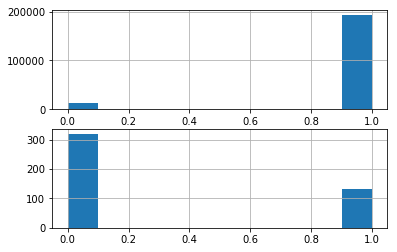

In [58]:
trainFile = "w:\Fedor\Kaggel\instacart\\newFeatures2.hdf"
trainDf = pd.read_hdf(trainFile)
trainDf.reset_index(drop=True,inplace=True)
print  trainDf.shape
features = preprocessData(trainDf.drop(['wasOrdered'],axis = 1))
ans = trainDf.wasOrdered.apply(lambda x: 1 if x else 0)

# create SGD classifier
classifier = LM.SGDClassifier()
classifier.fit(features,ans);
y_pr = classifier.predict(features) 
f1_score(ans,y_pr)

plt.subplot(211)
(y_pr==ans).hist()
plt.subplot(212)

(classifier.predict(features_test)==ans_test).hist()

In [19]:
def preprocessData(inp):
    df = inp.merge(products,left_on='product_id',right_index=True)
    df = df.assign(decay = df.lastOrder/df.periodicity).replace([np.inf, -np.inf], 0)
    df.fillna(0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    aisleEncoder =  prp.OneHotEncoder(sparse = False,n_values=aislesList.shape[0])
    
    aisleDf = pd.DataFrame(
        aisleEncoder.fit_transform(df.loc[:,'aisle_id'].values.reshape(-1, 1)),
        columns =['aisle_'+str(int(x)) for x in aislesList])
    
    aisleDf.drop('aisle_0', axis = 1, inplace=True)
    
    df = df.merge(aisleDf,left_index=True,right_index =True)
    X  = df.drop(['product_id','userId','product_name','aisle_id','department_id'],axis = 1)
    
    return X

In [ ]:
def save2File(fName,df):
    f = open(fName,'w')
    f.write('order_id,products\n')
    np.set_printoptions(linewidth = 500)
    for key, val in df.iteritems():
        k = np.array2string(val[1])[1:-1]+'\n'
        s = str(val[0])+','+k
        f.write(s)
    f.close()
    np.set_printoptions(linewidth = 75)

In [ ]:
def f1Score(y_true, y_pred):
    fullSet      = np.unique(np.hstack((y_pred,y_true)))
    intersection = np.intersect1d(y_true,y_pred).size
    precession   = intersection/float(y_pred.shape[0])
    recall       = intersection/float(y_true.shape[0])
    try:
        f1 = 2*precession*recall/(precession+recall)
    except ZeroDivisionError:
        f1 = 0
    return [precession, recall, f1]

In [11]:
orders = pd.read_csv('./data/orders.csv',index_col = 'order_id',usecols = ['order_id','user_id','eval_set','order_number','days_since_prior_order'])
orders.loc[:,'days_since_prior_order'].fillna(0,inplace = True) 
orders = orders.assign(date = orders.groupby('user_id').days_since_prior_order.transform(np.cumsum))

In [12]:
# now I want to test the model
trainUserId = orders.query("eval_set == 'train'").user_id.values
#testPriorOrderId = orders.query("(eval_set =='prior') and user_id in @testUsers").index.values
#testPriorSet = prior.query('order_id in @testPriorOrderId')

In [13]:
testUsers = trainUserId[-20:-10]
testOrders = orders.query('user_id in @testUsers')

In [14]:
usecols = ['order_id','product_id']
items = pd.concat([pd.read_csv('./data/order_products__train.csv',usecols = usecols),
                   pd.read_csv('./data/order_products__prior.csv',usecols = usecols)])

In [15]:
newDf = pd.DataFrame(columns = ['product_id','periodicity','absCount','lastOrder','wasOrdered'])
for tId, userGroup in testOrders.groupby('user_id'):
    print tId
    # вот это можно вычислить один раз для пользователя
    trainOrder = userGroup.query("eval_set != 'prior'")
    trainOrderDay = trainOrder.date.values

    # получаем предзаказы
    preOrders = userGroup.query("eval_set == 'prior' ").fillna(0).merge(
        items,left_index=True,right_on='order_id',copy = False,how='inner')

    fullBasket = preOrders.product_id.unique()

    r2 = preOrders.groupby('product_id').agg(
        {'date': lambda x: np.diff(x.values).mean(),
         'order_number': lambda x: x.shape[0]}
        ).rename(columns={'date': 'periodicity','order_number':'absCount'})

    r3 = preOrders.groupby('product_id').agg(
        {'date': lambda x: int(trainOrderDay - x.iloc[-1])}
        ).rename(columns={'date':'lastOrder'})

    r2 = r2.merge(r3,left_index=True,right_index=True)
    r2.reset_index(inplace=True)
    
    trainBasket = list(userGroup.query("(user_id == @tId) and eval_set != 'prior' ").fillna(0).merge(
        items,left_index=True,right_on='order_id',copy = False,how='inner').product_id.unique())

    r2 = r2.assign(wasOrdered = r2.product_id.apply(lambda x: x in trainBasket))
    # теперь можно рассчитать популярность каждого продукта в процентах
    #r2 = r2.assign(decay = r2.lastOrder/r2.periodicity)
    r2 = r2.assign(userId = tId)
    r2.fillna(0,inplace=True)
    r2.replace(np.inf,0,inplace=True)
    #r2.merge(products,left_on='product_id',right_index=True)
    #r2.to_hdf('newFeatures.hdf', 'features', format = 'table',append = True)
    newDf = pd.concat([newDf,r2])

206175


D:\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
D:\Anaconda2\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


206176
206177
206178
206181
206184
206185
206186
206188
206190


In [16]:
newDf.query('wasOrdered == True') 

,absCount,lastOrder,periodicity,product_id,userId,wasOrdered
11,1.0,14.0,0.000000,20734.0,206175.0,True
15,4.0,14.0,19.333333,25931.0,206175.0,True
34,1.0,79.0,0.000000,45007.0,206175.0,True
37,1.0,34.0,0.000000,47766.0,206175.0,True
14,9.0,12.0,26.875000,21709.0,206176.0,True
24,2.0,12.0,164.000000,28920.0,206176.0,True
33,9.0,20.0,22.125000,37709.0,206176.0,True
1,1.0,42.0,0.000000,311.0,206177.0,True
13,1.0,42.0,0.000000,10132.0,206177.0,True
26,5.0,8.0,34.000000,21903.0,206177.0,True


In [21]:
features_test = preprocessData(newDf.drop(['wasOrdered'],axis = 1))
ans_test = newDf.wasOrdered.apply(lambda x: 1 if x else 0)

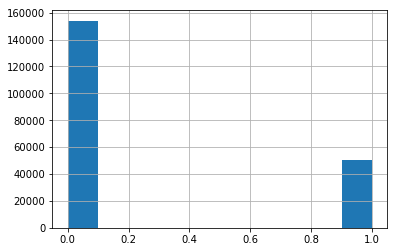

In [55]:
(classifier.predict(features)==ans).hist()

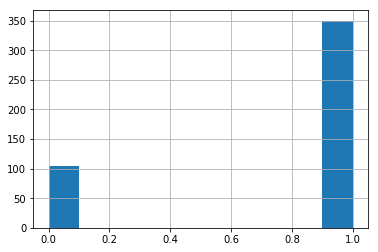

In [54]:
(classifier.predict(features_test)==ans_test).hist()